# Test Data
dy_dt = lambda t, y : 4*t*np.sqrt(y)
y = lambda t: y0*(1+t**2)**2
y0=1

In [1]:
from scipy.integrate import quadrature
from functools import reduce
from pandas import DataFrame as DF
from matplotlib import pyplot as plt
import numpy as np
from scipy.interpolate import lagrange

In [2]:
dy_dt = lambda t, y : 4*t*np.sqrt(y)
y = lambda t: y0*(1+t**2)**2
y0=1

# Euler and RK 4 and AB 4

Reusable class to calculate approximations using forward euler and rk4. SDC inherits.

In [3]:
# class Schemes: 
#     soln = []
    
#     def __init__(self, v_field, start, stop, h, init_conditions):
#         self.vector_field = v_field
#         self.ics = init_conditions
#         self.a = start
#         self.b = stop
#         self.times = np.arange(self.a,self.b,h)  
#         self.h = h
          
#     def prep_preds(scheme):
#         def wrapper(self):
#             n = self.times.size
#             x = np.zeros(n)
#             x[0] = self.ics
#             self.soln = scheme(self,x)
#             return self.times, self.soln
#         return wrapper
 
#     @prep_preds
#     def euler(self, x):
#         for k, t in enumerate(self.times[:-1]):
#             x[k+1] = x[k]+self.h*self.vector_field(t,x[k])
#         return x
    
#     @prep_preds
#     def rk4(self, x):
#         for k, t in enumerate(self.times[:-1]):
#             f1 = self.vector_field(t,x[k])
#             f2 = self.vector_field(t+0.5*self.h, x[k]+0.5*self.h*f1)
#             f3 = self.vector_field(t+0.5*self.h, x[k]+0.5*self.h*f2)
#             f4 = self.vector_field(t+self.h, x[k]+self.h*f3)
#             x[k+1] = x[k]+self.h/6*(f1+2*f2+2*f3+f4)
#         return x

#     @prep_preds
#     def ab4(self,x):
#         for k,t in enumerate(self.times[:-1]):
#             if (k < 3):
#                 x[k+1] = x[k]+self.h*self.vector_field(t,x[k])
#                 pass
#             f1 = self.vector_field(t,x[k])
#             f2 = self.vector_field(self.times[k-1], x[k-1])
#             f3 = self.vector_field(self.times[k-2], x[k-2])
#             f4 = self.vector_field(self.times[k-3], x[k-3])
#             x[k+1] = x[k] + self.h/24 * (55*f1 - 59*f2 + 37*f3 - 9*f4)
#         return x
class Schemes: 
    soln = []
    
    def __init__(self, v_field, start, stop, h, init_conditions):
        self.vector_field = v_field
        self.ics = init_conditions
        self.a = start
        self.b = stop
        self.times = np.arange(self.a,self.b,h)  
        self.h = h
          
    def prep_preds(scheme):
        def wrapper(self):
            #start = time()
            n = self.times.size
            x = np.zeros(n)
            x[0] = self.ics
            self.soln = scheme(self,x)
            #end = time()
            return self.times, self.soln#, round(end-start, 2)
        return wrapper
 
    @prep_preds
    def euler(self, x):
        for k, t in enumerate(self.times[:-1]):
            x[k+1] = x[k]+self.h*self.vector_field(t,x[k])
        return x
    
    @prep_preds
    def rk4(self, x):
        for k, t in enumerate(self.times[:-1]):
            f1 = self.vector_field(t,x[k])
            f2 = self.vector_field(t+0.5*self.h, x[k]+0.5*self.h*f1)
            f3 = self.vector_field(t+0.5*self.h, x[k]+0.5*self.h*f2)
            f4 = self.vector_field(t+self.h, x[k]+self.h*f3)
            x[k+1] = x[k]+self.h/6*(f1+2*f2+2*f3+f4)
        return x

    @prep_preds
    def ab4(self,x):
        for k,t in enumerate(self.times[:-1]):
            if (k < 3):
                f1 = self.vector_field(t,x[k])
                f2 = self.vector_field(t+0.5*self.h, x[k]+0.5*self.h*f1)
                f3 = self.vector_field(t+0.5*self.h, x[k]+0.5*self.h*f2)
                f4 = self.vector_field(t+self.h, x[k]+self.h*f3)
                x[k+1] = x[k]+self.h/6*(f1+2*f2+2*f3+f4)
                #x[k+1] = x[k]+self.h*self.vector_field(t,x[k])
            else:    
                f1 = self.vector_field(t,x[k])
                f2 = self.vector_field(self.times[k-1], x[k-1])
                f3 = self.vector_field(self.times[k-2], x[k-2])
                f4 = self.vector_field(self.times[k-3], x[k-3])
                x[k+1] = x[k] + self.h/24 * (55*f1 - 59*f2 + 37*f3 - 9*f4)
        return x


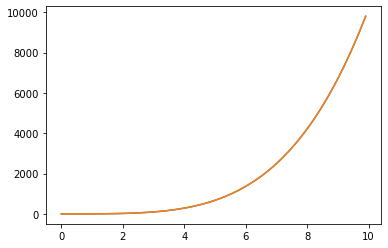

In [20]:
times, y_pred = Schemes(v_field=dy_dt, 
                   start=0, 
                   stop=10, 
                   h=0.1, 
                   init_conditions=y0).ab4()

plt.plot(times, y_pred)
plt.plot(times, [y(t) for t in times])

In [4]:
def beta(M):
    '''
    Generates beta coefficients for Adam-Bashforth integrating scheme
    These coefficients are stored in reversed compared to conventional
    Adam-Bashforth implementations (the first element of beta corresponds to
    earlier point in time).
    input:
    M: the order of Adam-Bashforth scheme
    '''
    if M == 2:
        return np.array([-1./2, 3./2])
    elif M == 3:
        return np.array([5./12, -16./12, 23./12])
    elif M == 4:
        return np.array([-9./24, 37./24, -59./24, 55./24])
    elif M == 5:
        return np.array([251./720, -1274./720, 2616./720, -2774./720, 1901./720])
    elif M == 6:
        return np.array([-475./720, 2877./720, -7298./720, 9982./720, -7923./720, 4277./720])


def Ab4(F,T,y0,N):
    betavec = beta(4)
    h = float(T)/N
    ts = np.linspace(0,T,N+1)
    d = len(y0)
    Y = np.zeros((N+1,d))
    Y[0,:] = y0
    
    for t in range(3):
        KK1 = F(ts[t],Y[t,:])
        KK2 = F(ts[t]+h/2, Y[t,:]+KK1*h/2)
        KK3 = F(ts[t]+h/2, Y[t,:]+KK2*h/2)
        KK4 = F(ts[t]+h,Y[t,:]+KK3*h)
        Y[t+1,:] = Y[t,:] + h*(KK1 + 2*KK2 + 2*KK3 + KK4)/6
    for t in range(3,N):
        L = np.array([F(ts[t-3],Y[t-3,:]),F(ts[t-2],Y[t-2,:]),F(ts[t-1],Y[t-1,:]),F(ts[t],Y[t,:])])
        Y[t+1,:] = Y[t,:] +h*np.dot(betavec,L)
        
    return Y

def Runge_Kutta_4(times,f,y0):
    no_of_times = times.size                                                
    Y = np.zeros((no_of_times))             
                                                      
    Y[0] = y0  
    for i in range(no_of_times-1):  
        h = times[i+1] - times[i]  
        delta1 = f(times[i],Y[i]) * h 
        delta2 = f(times[i]+1/2*h,Y[i]+1/2*delta1) * h  
        delta3 = f(times[i]+h/2,Y[i]+delta2/2) * h 
        delta4 = f(times[i]+h,Y[i]+delta3) * h 
        Y[i+1] = Y[i] + 1/6*(delta1+2*delta2+2*delta3+delta4) 
    return Y


def Euler(times, f, y0):
    no_of_times = times.size 
    Y = np.zeros((no_of_times))
    
    Y[0] = y0
    for i in range(no_of_times-1):
        h = times[i+1] - times[i]
        Y[i+1] = Y[i] + h*f(times[i],Y[i])
        
    return Y



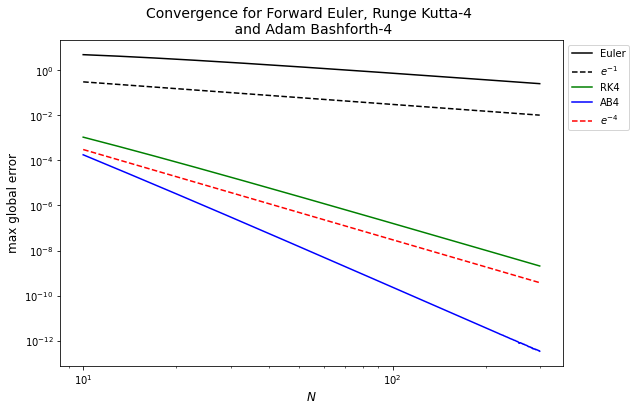

In [5]:
#Finding order of convergence for Euler method

errorlist = []
stepsizelist = []

for i in range(10,300):    #timestep sizes from h=1 t h=0.01
    T = np.linspace(0, 2, i+1)
    K = Euler(T,dy_dt,1)
    stepsizelist.append(i)
    m = [abs(K[j] - y(T[j])) for j in range(i)]
    errorlist.append(max(m))
    
errorlist1 = []
stepsizelist1 = []
    
for i in range(10,300):    #timestep sizes from h=1 t h=0.01
    T = np.linspace(0, 2, i+1)
    K = Runge_Kutta_4(T,dy_dt,1)
    stepsizelist1.append(i)
    m = [abs(K[j] - y(T[j])) for j in range(i)]
    errorlist1.append(max(m))
    
errorlist2 = []
stepsizelist2 = []
    
for i in range(10,300):    #timestep sizes from h=1 t h=0.01
    T = np.linspace(0, 2, i+1)
    K = Ab4(dy_dt,2,np.array([1]),i)
    stepsizelist2.append(i)
    m = [abs(K[j] - y(T[j])) for j in range(i)]
    errorlist2.append(max(m))
    
test = [3/(i) for i in stepsizelist]
test1 = [3/(i**4) for i in stepsizelist]
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
plt.plot(stepsizelist, errorlist, 'k-', markersize=2,label ="Euler")
plt.plot(stepsizelist, test, 'k--', markersize=2, label = "$e^{-1}$")
plt.plot(stepsizelist1, errorlist1, 'g-', markersize=2,label ="RK4")
plt.plot(stepsizelist2, errorlist2, 'b-', markersize=2,label ="AB4")
plt.plot(stepsizelist1, test1, 'r--', markersize=2,label ="$e^{-4}$")
ax.set_xscale('log')
ax.set_yscale('log')
#plt.plot(stepsizelist, errorlist, 'r-', markersize=2)
plt.xlabel('$N$',fontsize = 12)
plt.ylabel(r'max global error',fontsize = 12)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.title('Convergence for Forward Euler, Runge Kutta-4 \n and Adam Bashforth-4',fontsize = 14)
# plt.savefig('Eulerorder.png')
plt.show()

# Algorithm 1.1 IDC(p,M)-FE
From SIAM Parallel High-Order Integrators

In [23]:
def idc_fe(a,b,alpha, N, p, f):
    """Perform IDCp-FE
    Input: (a,b) endpoints; alpha ics; N #intervals; p order; f vector field.
    Require: N divisible by M=p-1, with JM=N. M is #corrections.
    Return: eta_sol
    """

    # Initialise, J intervals of size M 
    if not type(N) is int:
        raise TypeError('N must be integer')
    M = p-1
    if N % M !=0:
        raise Exception('p-1 does not divide N')
    dt = (b-a)/N
    J = int(N/M)
    S = np.zeros([M,M+1])

    # M corrections, M intervals I, of size J 
    eta_sol = np.zeros(N+1)
    eta_sol[0]=alpha
    eta = np.zeros([M+1, J, M+1])
    t = np.zeros([J,M+1])
    eta_overlaps = np.zeros([J])

    # Precompute integration matrix
    for m in range(M):
        for i in range(M+1):
            c = lambda t,i : reduce(lambda x, y: x*y, 
                                [(t-k)/(i-k) for k in range(M) if k!=i])
            S[m,i] = quadrature(c, m, m+1, args=(i))[0] 

    for j in range(J):
        # Prediction Loop
        eta[0, j, 0] = alpha if j == 0 else eta_overlaps[j]
        for m in range(M):
            t[j,m] = (j*M+m)*dt
            eta[0,j,m+1] = eta[0,j,m] + dt*f(t[j,m],eta[0,j,m])


        # Correction Loops
        for l in range(1,M+1):
            eta[l,j,0] = eta[l-1,j,0]
            for m in range(M):
                # Error equation, Forward Euler
                term1 = dt*(f(t[j,m],eta[l,j,m])-f(t[j,m],eta[l-1,j,m]))
                term2 = dt*np.sum([ S[m,i] * f(t[j,i],eta[l-1,j,i]) for i in range(M)])
                eta[l,j,m+1] = eta[l,j,m] + term1 + term2
        

        eta_sol[j*M+1:(j+1)*M +1] = eta[M,j,1:]
        if j != J-1:
            eta_overlaps[j+1] = eta[M,j,M] 

    return np.arange(a,b+dt,dt)[:-1], eta_sol[:-1]


In [24]:
N=200
a,b = 0,10
times = np.linspace(a,b,N+1)

# a, b , alpha, N, p
y_preds = [idc_fe(a,b, y0, N, p, dy_dt) for p in [6,3]]
# since 5 and 2 divide 10 
y_true = [y(t) for t in times]


plt.plot(times,y_true)
plt.plot(times, y_preds[0])
plt.plot(times, y_preds[1])
plt.legend(['y_true','y_pred p=6', 'y_pred p=3'])

ValueError: x and y must have same first dimension, but have shapes (201,) and (2, 200)

In [ ]:
times2 = np.linspace(0, 1, 11)
# a, b , alpha, N, p
y_pred = idc_fe(0,1,1,10,3, dy_dt)
y_true = [y(t) for t in times2]
plt.plot(times2, y_true, times2, y_pred)
plt.legend(['y_true', 'y_pred'])

## Order of convergence

In [ ]:
errors = []
h_sizes = []

for i in [6,11,21,41,101,201]:   
    t = np.linspace(0, 2, i)
    y_pred = idc_fe(0,2,1,i-1,6, dy_dt)
    h_sizes.append(1/(i-1))
    error = [abs(y_pred[j] - y(t[j])) for j in range(i)]
    errors.append(max(error))
    
log_errors = [np.log(i) for i in errors]
log_hs = [np.log(i) for i in h_sizes]
print(log_hs)

fig, ax = plt.subplots(1, 1, figsize=(9, 6))
plt.plot(log_hs, log_errors, 'b-', markersize=2)
plt.grid()
plt.xlabel('log(h)')
plt.ylabel(r'log(max global error)')
plt.title('IDC(p,M)-FE')
plt.show() 

# Algorithm 1.2 RIDC(p,K)-FE

In [5]:
def ridc_fe(a,b,alpha, N, p, K, f):
    """Perform IDCp-FE
    Input: (a,b) endpoints; alpha ics; N #intervals; p order; K intervals; f vector field.
    Require: N divisible by K, with JK=N. M is #corrections. J groups of K intervals.
    Return: eta_sol
    """

    # Initialise, J intervals of size M 
    if not isinstance(N, int):
        raise TypeError('N must be integer')
    M = p-1
    if N % K !=0:
        raise Exception('K does not divide N')
    dt = (b-a)/N
    J = int(N/K)
    S = np.zeros([M,M+1])

    # M corrections, M intervals I, of size J 
    eta_sol = np.zeros(N+1)
    eta_sol[0]=alpha
    eta = np.zeros([M+1, J, K+1])
    t = np.zeros([J,K+1])
    eta_overlaps = np.zeros([J])

    # Precompute integration matrix
    for m in range(M):
        for i in range(M+1):
            c = lambda t,i : reduce(lambda x, y: x*y, 
                                [(t-k)/(i-k) for k in range(M) if k!=i])
            S[m,i] = quadrature(c, m, m+1, args=(i))[0] 

    for j in range(J):
        # Prediction Loop
        eta[0, j, 0] = alpha if j == 0 else eta_overlaps[j]
        for m in range(K):
            t[j,m] = (j*K+m)*dt
            eta[0,j,m+1] = eta[0,j,m] + dt*f(t[j,m],eta[0,j,m])


        # Correction Loops
        for l in range(1,M+1):
            eta[l,j,0] = eta[l-1,j,0]
            for m in range(M):
                # Error equation, Forward Euler
                term1 = dt*(f(t[j,m],eta[l,j,m])-f(t[j,m],eta[l-1,j,m]))
                term2 = dt*np.sum([S[m,i] * f(t[j,i],eta[l-1,j,i]) for i in range(M)])
                eta[l,j,m+1] = eta[l,j,m] + term1 + term2
            for m in range(M,K):
                term1 = dt*(f(t[j,m],eta[l,j,m])-f(t[j,m],eta[l-1,j,m]))
                term2 = dt*np.sum([S[M-1,i] * f(t[j,m-M+i],eta[l-1,j,m-M+i]) for i in range(M)])
                eta[l,j,m+1] =  eta[l,j,m] + term1 + term2
        

        eta_sol[j*K+1:(j+1)*K +1] = eta[M,j,1:]
        if j != J-1:
            eta_overlaps[j+1] = eta[M,j,K] 
            
    return eta_sol

In [ ]:
ts = np.linspace(0, 1, 101)
# a, b , alpha, N, p, K, f
y_pred = ridc_fe(a=0,b=1,alpha=1,N=100,p=3,K=2,f=dy_dt)
y_true = [y(t) for t in ts]
plt.plot(ts, y_true, ts, y_pred)
plt.legend(['y_true', 'y_pred'])

In [ ]:
errors = []'exact'
ks = []'exact'
'exact'
for k in [5,10,20,25,50]:   
    # K = 5
    t = np.linspace(0, 2, 101)
    y_pred = ridc_fe(0,2,1,100,5, k,dy_dt)
    ks.append(np.log(k))
    error = [abs(y_pred[j] - y(t[j])) for j in range(len(t))]
    errors.append(np.log(max(error)))
    

fig, ax = plt.subplots(1, 1, figsize=(9, 6))
plt.plot(ks, errors,'b-', markersize=2)
plt.grid()
plt.xlabel('log(k)')
plt.ylabel(r'log(max global error)')
plt.title('RIDC(p,K)-FE')
plt.show() 

# Algorithm 1.2 RIDC(p,K)-AB(2)

In [6]:
def ridc_ab(a,b,alpha, N, p, K, f):
    """Perform IDCp-FE
    Input: (a,b) endpoints; alpha ics; N #intervals; p order; K intervals; f vector field.
    Require: N divisible by K, with JK=N. M is #corrections. J groups of K intervals.
    Return: eta_sol
    """

    # Initialise, J intervals of size M 
    if not isinstance(N, int):
        raise TypeError('N must be integer')
    M = p-1
    if N % K !=0:
        raise Exception('K does not divide N')
    dt = (b-a)/N
    J = int(N/K)
    S = np.zeros([M,M+1])

    # M corrections, M intervals I, of size J 
    eta_sol = np.zeros(N+1)
    eta_sol[0]=alpha
    eta = np.zeros([M+1, J, K+1])
    t = np.zeros([J,K+1])
    eta_overlaps = np.zeros([J])

    # Precompute integration matrix
    for m in range(M):
        for i in range(M+1):
            c = lambda t,i : reduce(lambda x, y: x*y, 
                                [(t-k)/(i-k) for k in range(M) if k!=i])
            S[m,i] = quadrature(c, m, m+1, args=(i))[0] 

    for j in range(J):
        # Prediction Loop ADAM BASHFORTH
        eta[0, j, 0] = alpha if j == 0 else eta_overlaps[j]
        eta[0,j,1] = eta[0,j,0] + dt*f(t[j,0],eta[0,j,0])
        t[j,0], t[j,1] = j*K*dt, (j*K+1)*dt
        for m in range(K-1):
            t[j,m+1] = (j*K+m+1)*dt
            eta[0,j,m+2] = eta[0,j,m+1] \
                            +1.5*dt*f(t[j,m+1],eta[0,j,m+1]) \
                            -0.5*dt*f(t[0,m],eta[0,j,m])


        # Correction Loops
        for l in range(1,M+1):
            eta[l,j,0] = eta[l-1,j,0]
            for m in range(M):
                # Error equation, Forward Euler
                term1 = dt*(f(t[j,m],eta[l,j,m])-f(t[j,m],eta[l-1,j,m]))
                term2 = dt*np.sum([S[m,i] * f(t[j,i],eta[l-1,j,i]) for i in range(M)])
                eta[l,j,m+1] = eta[l,j,m] + term1 + term2
            for m in range(M,K):
                term1 = dt*(f(t[j,m],eta[l,j,m])-f(t[j,m],eta[l-1,j,m]))
                term2 = dt*np.sum([S[M-1,i] * f(t[j,m-M+i],eta[l-1,j,m-M+i]) for i in range(M)])
                eta[l,j,m+1] =  eta[l,j,m] + term1 + term2
        

        eta_sol[j*K+1:(j+1)*K +1] = eta[M,j,1:]
        if j != J-1:
            eta_overlaps[j+1] = eta[M,j,K] 
            
    return np.arange(a,b+dt,dt), eta_sol

In [ ]:
ts = np.linspace(0, 1, 101)
# a, b , alpha, N, p, K, f
y_pred = ridc_ab(a=0,b=1,alpha=1,N=100,p=3,K=2,f=dy_dt)
y_true = [y(t) for t in ts]
plt.plot(ts, y_true, ts, y_pred)
plt.legend(['y_true', 'y_pred'])

In [ ]:
errors = []
ks = []

for k in [5,10,20,25,50]:   
    # K = 5
    t = np.linspace(0, 2, 101)
    y_pred = ridc_ab(0,2,1,100,5, k,dy_dt)
    ks.append(np.log(k))
    error = [abs(y_pred[j] - y(t[j])) for j in range(len(t))]
    errors.append(np.log(max(error)))
    

fig, ax = plt.subplots(1, 1, figsize=(9, 6))
plt.plot(ks, errors,'b-', markersize=2)
plt.grid()
plt.xlabel('log(k)')
plt.ylabel(r'log(max global error)')
plt.title('RIDC(p,K)-AB(2)')
plt.show() 

# COMPARING Order of Convergence
TEST: y'=4tsqrt(y)    
SOLN: y=y0*(1+t^2)^2 with (ICS) y0=1 

change timesteps

In [ ]:
def plot_df(df, h):
    fig, [[ax1, ax2], [ax3,ax4]]= plt.subplots(nrows=2, ncols=2, figsize=(15,10))
    df.plot(title='Exact vs Euler vs RK4 vs IDC with h='+str(h), 
            x='times', 
            y=['euler','rk4','idc', 'exact'],
            ax=ax1)
    df.plot(title='Error of Euler vs time with h='+str(h), 
            x='times', 
            y='error_euler',
            ax=ax2)
    df.plot(title='Error of RK4 vs time with h='+str(h), 
            x='times', 
            y= 'error_rk4',
           ax=ax3)
    df.plot(title='Error of IDC vs time with h='+str(h), 
            x='times', 
            y= 'error_idc',
           ax=ax4)

In [7]:
def IDC(a,b,N,p,y0):
    #(a,b)-endpoints, N-number of steps, p-order of method, y0-I.C

    h = (b-a)/N  #stepsize
    M = p-1  
    J = int(N/M)
    sol_list = np.zeros(N+1)
    sol_list[0] = y0
    T = np.zeros((J,M+1))  #times
    Y = np.zeros((J,M+1))  #approx solution
    Y1 = np.zeros((J,M+1))   #corrected solution
    Y[0,0]= y0            #inital value
    S = np.zeros((M,M+1))  #integration matrix
    
    for m in range(M):   # calculating integration matrix
        for i in range(M+1):
            x = np.arange(M+1)  # Construct a polynomial
            y = np.zeros(M+1)   # which equals 1 at i, 0 at other points
            y[i] = 1
            p = lagrange(x, y)  # constructs polynomial
            para = np.poly1d.integ(p)  
            S[m,i] = para(m+1) - para(m)  #finds definite integral of polynomial and adds to integral matrix
            
    for j in range(J):
        for m in range(M):   #prediction
            T[j,m] = (j*M + m)*h
            T[j,m+1] = (j*M + m+1)*h
            Y[j,m+1] = Y[j,m] + h*(4*T[j,m]*Y[j,m]**(0.5)) #Eulers forward method  
            
        for l in range(M+1):   #correction
            Y1[j,0] = Y[j,0]
            
            for m in range(M):  
                g = 0
                for k in range(M+1):
                    g = g + S[m,k]*(4*T[j,k]*Y[j,k]**(0.5))
   
                Y1[j,m+1] = Y1[j,m] + h*((4*T[j,m]*Y[j,m]**0.5)-(4*T[j,m]*Y1[j,m]**0.5)) + h*g  #solve error equation with forward Euler
            Y[j,:] = Y1[j,:]
    
        sol_list[j*M+1:j*M+M+1] = Y1[j,1:M+1]
        if j!=J-1:           #set initial value for next iteration
            Y[j+1,0] = Y1[j,M]
            
    return np.arange(a,b+h,h)[:-1], sol_list[:-1]

In [48]:
def analyse_scheme(dy_t, y, a, b, ics, step_sizes, order_idc):
    max_global_err = []
    for i in range(len(step_sizes)):
        h = step_sizes[i]
        # y_pred = Schemes(v_field=dy_dt,
                        #  start=a, stop=b, h=h, init_conditions=ics)

        times = np.arange(a, b, h)
        exact = [y(t) for t in times]
        
        df = DF({'times': times,
                    # 'euler': y_pred.euler()[1],
                    # 'rk4':  y_pred.rk4()[1],
                    # 'ab4': y_pred.ab4()[1],
                    'exact': exact})
        idc_err = []
        for order in order_idc:
            ts, df['idc_' + str(order)] = idc_fe(a=a, b=b, alpha=y0, N=int((b-a)/h), p=order, f=dy_dt)
            df['exact_'+str(order)] = [y(t) for t in ts]
            idc_err = idc_err + [df['exact_'+str(order)].sub(df['idc_' + str(order)]).abs().max()]
            
        # df['error_euler'] = df['exact'].sub(df['euler']).abs()
        # df['error_rk4'] = df['exact'].sub(df['rk4']).abs()
        # df['error_ab4'] = df['exact'].sub(df['ab4']).abs()
        max_global_err.append(idc_err)
                                    # +[df['error_euler'].max(),
                                    # df['error_rk4'].max(),
                                    # df['error_ab4'].max()])

    return max_global_err

In [49]:
h_sizes = [10**i for i in [-1, -2, -3, -4]]

start, stop = 0, 1

N = [1/h for h in h_sizes]

max_global_err = analyse_scheme(dy_dt, y, start, stop, y0, h_sizes, [3,6,11])
print(max_global_err)

[[0.014956962598472678, 8.30860606981787e-08, 4.8405723873656825e-14], [0.00026224386306683556, 9.237055564881302e-14, 2.220446049250313e-15], [2.7573440140038485e-06, 3.1086244689504383e-15, 1.3322676295501878e-15], [2.7710547634285376e-08, 1.021405182655144e-14, 1.199040866595169e-14]]


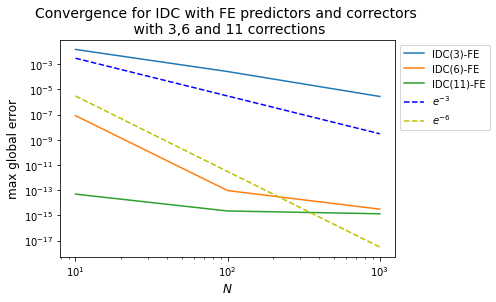

In [62]:
test = [3/(i**3) for i in N[:-1]]
test1 = [3/(i**6) for i in N[:-1]]
test2 = [1/(i**11) for i in N[:-1]]

l1, l2, l3 = plt.plot(N[:-1],max_global_err[:-1])
l1.set_label('IDC(3)-FE')
l2.set_label('IDC(6)-FE')
l3.set_label('IDC(11)-FE')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('log Maximum Global Error')
plt.xlabel('log Number of time-steps')
l4 = plt.plot(N[:-1], test, 'b--', markersize=2, label = '$e^{-3}$')
l5 = plt.plot(N[:-1], test1, 'y--', markersize=2, label = '$e^{-6}$')
# plt.legend([l1,l2,l3,l4,l5],['IDC(3)-FE', 'IDC(6)-FE', 'IDC(11)-FE', '$e^{-3}$', '$e^{-6}$' ], )


# plt.plot(N[:-1], test2, 'g--', markersize=2,label ="$e^{-11}$")
ax.set_xscale('log')
ax.set_yscale('log')
#plt.plot(stepsizelist, errorlist, 'r-', markersize=2)
plt.xlabel('$N$',fontsize = 12)
plt.ylabel(r'max global error',fontsize = 12)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.title('Convergence for IDC with FE predictors and correctors \n with 3,6 and 11 corrections',fontsize = 14)
# plt.savefig('Eulerorder.png')
plt.show()




plt.show()

In [ ]:
# slopes = [1/linregress(np.log(np.array(max_global_err)[:-1,i]), np.log(np.array(N[:-1])))[0] for i in range(6)]
# slopes